# Homework 1: Linear Regression
## CSCE 633 - Summer 2024
### Arya Rahmanian

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

### Data Preprocessing

Reading the csv files and printing the first 5 rows along with the shape of the training data

In [74]:
train_data = pd.read_csv("data/data_train-2.csv")
test_data = pd.read_csv("data/data_test-1.csv")

print(train_data.head())
print(train_data.shape)

   Unnamed: 0  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0           0        797.0    -200.0       2.1          593.0    146.0   
1           1       1282.0    -200.0      11.0         1013.0    354.0   
2           2        891.0    -200.0       7.6          882.0    342.0   
3           3       1285.0    -200.0      18.1         1243.0    481.0   
4           4        892.0    -200.0       7.3          869.0     71.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1212.0     72.0         984.0        494.0  10.8  49.7  0.6429  
1         545.0    141.0        1384.0       1287.0  17.4  50.6  0.9989  
2         885.0    149.0         950.0        894.0   7.8  33.9  0.3594  
3         599.0    173.0        1815.0       1582.0  26.4  41.9  1.4237  
4         953.0     77.0        1363.0        632.0  37.4  14.7  0.9295  
(6250, 13)


In [111]:
missing_values = train_data.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

#total number of missing values
total_missing = missing_values.sum()
print("Total number of missing values:", total_missing)

#  drop missing value rows
train_data_cleaned = train_data.dropna(inplace=False)
test_data_cleaned = test_data.dropna(inplace=False)
print("Shape after dropping rows with missing data:", train_data_cleaned.shape)


Number of missing values in each column:
 Unnamed: 0        0
PT08.S1(CO)      77
NMHC(GT)         77
C6H6(GT)         77
PT08.S2(NMHC)    77
NOx(GT)          77
PT08.S3(NOx)     77
NO2(GT)          77
PT08.S4(NO2)     77
PT08.S5(O3)      77
T                77
RH               77
AH               77
dtype: int64
Total number of missing values: 924
Shape after dropping rows with missing data: (6173, 13)


In [76]:
label_column = 'PT08.S1(CO)'
features = train_data_cleaned.drop(columns=[label_column])
features_raw = features.drop(columns="Unnamed: 0")
label_raw = train_data_cleaned[label_column]

print("features shape:", features.shape)

features shape: (6173, 12)


## Plotting Data

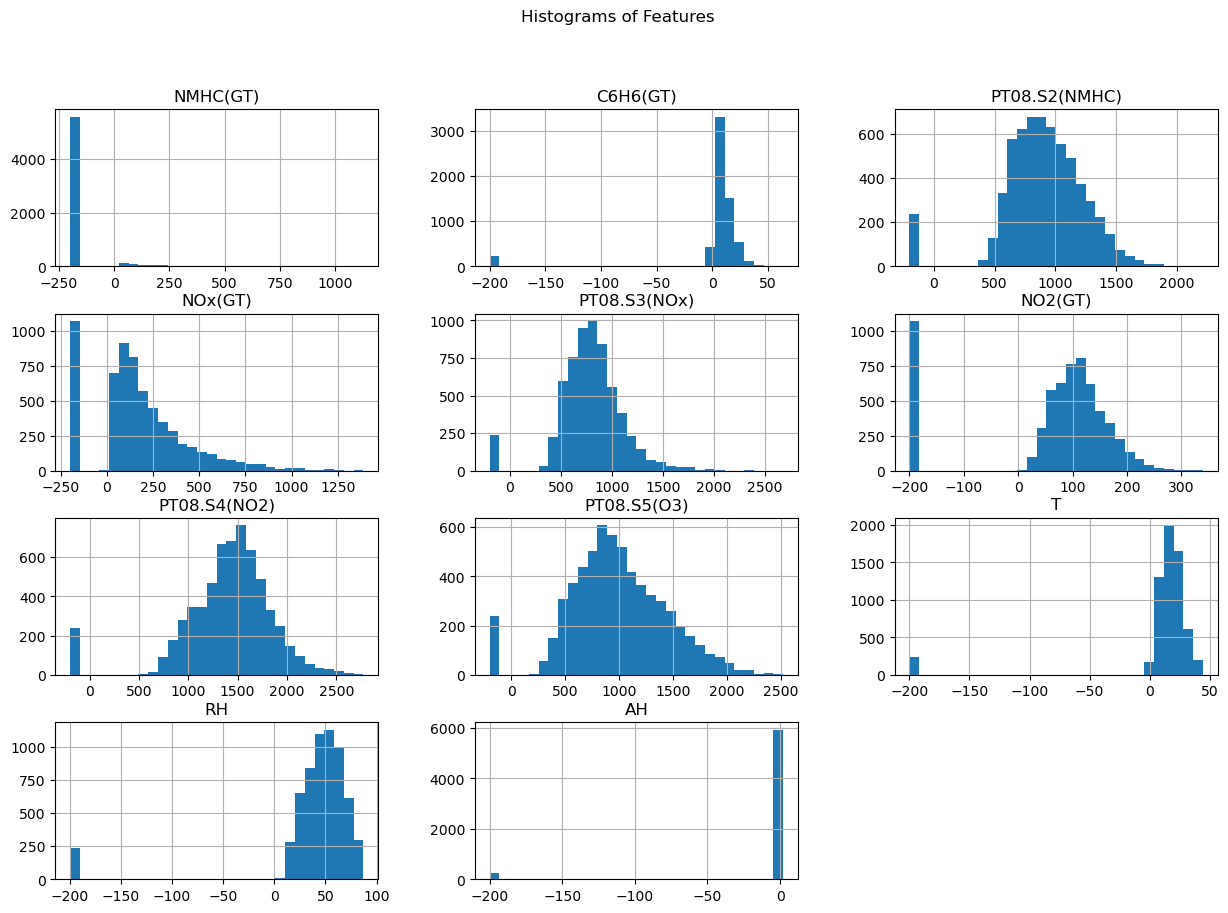

In [77]:
#plot histograms of features
features_raw.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Features")
plt.show()

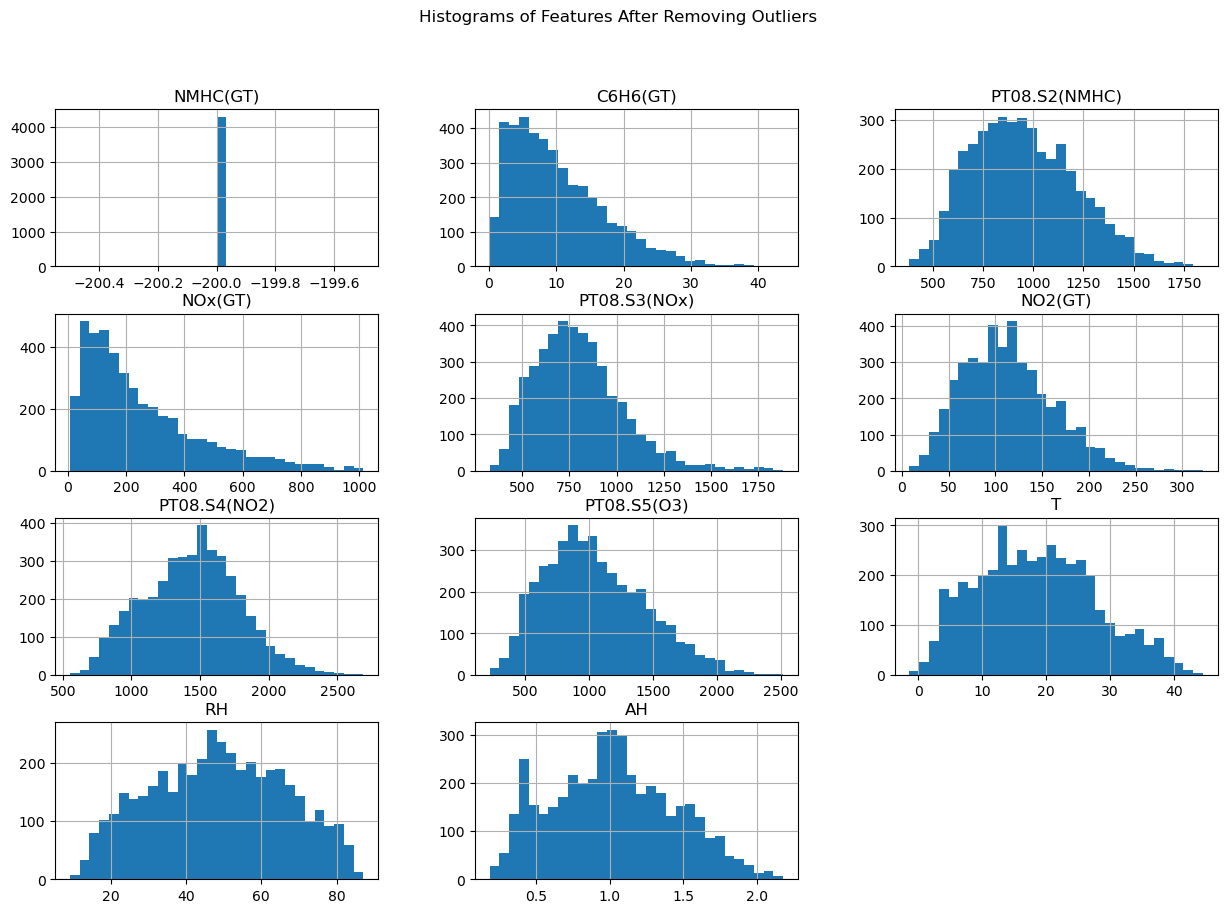

In [78]:
# IQR method to remove outliers
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 3*IQR
    upper_bound = Q3 + 3*IQR
    return df[~((df<lower_bound) | (df>upper_bound)).any(axis=1)]

#remove outliers
train_data_no_outliers = remove_outliers(train_data_cleaned)

#extract features and label
label_column = 'PT08.S1(CO)'
features = train_data_no_outliers.drop(columns=[label_column])
features = features.drop(columns="Unnamed: 0")
label = train_data_no_outliers[label_column]

# plotting
features.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Features After Removing Outliers")
plt.show()


### Preprocessing explained
After plotting the data, I saw that most features had some outliers and I decided to remove them using the IQR method. By calculating the first and third quartiles, I was able to clean up the data and smooth it out.

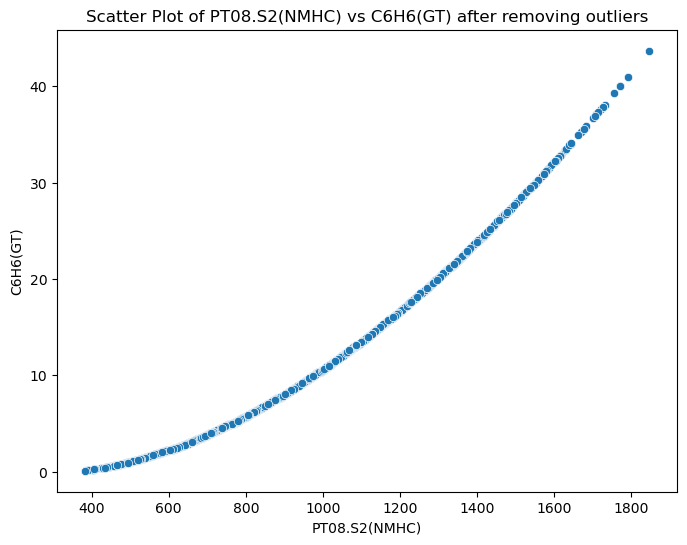

Correlation between PT08.S2(NMHC) and C6H6(GT): 0.98


In [79]:
import seaborn as sns
#Picking 2 features and create a scatter plot 
feature1 = 'PT08.S2(NMHC)'  
feature2 = 'C6H6(GT)'  

plt.figure(figsize=(8, 6))
sns.scatterplot(x=features[feature1], y=features[feature2])
plt.title(f"Scatter Plot of {feature1} vs {feature2} after removing outliers")
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# Calculate correlation
correlation = features[[feature1, feature2]].corr().iloc[0, 1]
print(f"Correlation between {feature1} and {feature2}: {correlation:.2f}")

Correlation of 0.98 and visual inspection shows that they are highly correlated

## Correlation Matrix

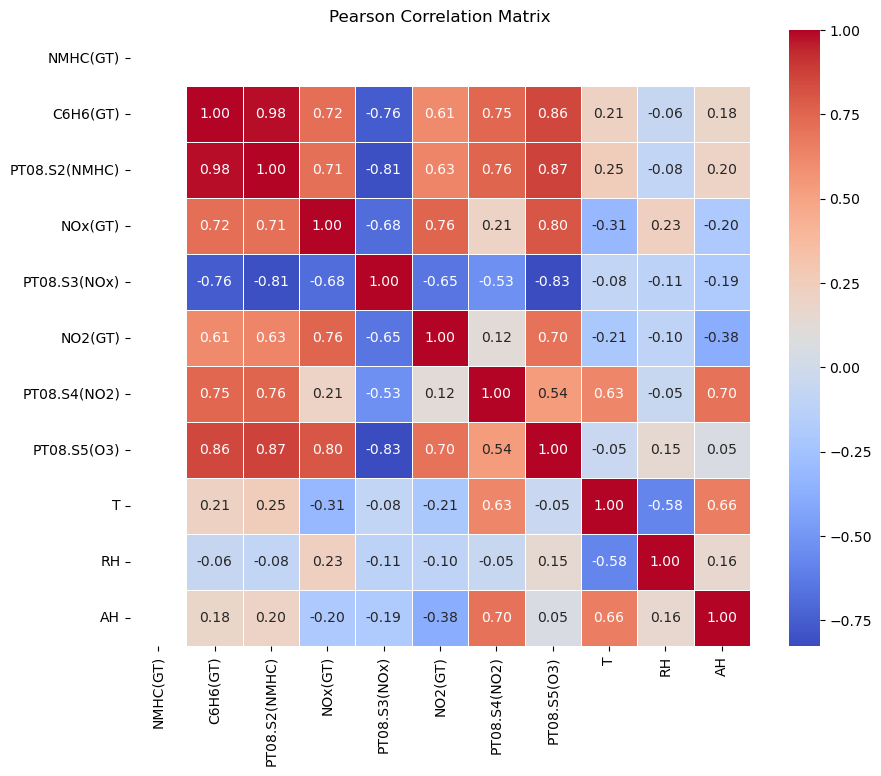

In [80]:
correlation_matrix = features.corr()

C = correlation_matrix.values

#plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Pearson Correlation Matrix")
plt.show()


## Building Linear Regression Model

In [119]:
class LinearRegression:   
    def __init__(self, learning_rate=0.000000001, iterations=10000):        
        self.learning_rate = learning_rate
        self.iterations    = iterations
    
    # Function for model training         
    def fit(self, X, Y):
        # weight initialization
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)          
        self.b = 0
        
        # data
        self.X = X         
        self.Y = Y
        
        # gradient descent learning to update the weights in each iteration               
        for i in range(self.iterations) :              
            self.update_weights()  

    # Helper function to update weights in gradient descent      
    def update_weights(self):
        
        Y_pred = self.predict(self.X) # make predictions on data and calculate gradients 
        dW = - (2 * (self.X.T).dot(self.Y - Y_pred)) / self.m  # derivative of weights
        db = - 2 * np.sum(self.Y - Y_pred) / self.m # derivative of bias
        
        self.W = self.W - dW * self.learning_rate # update the weights using the learning rate and derivative we calculated in the previous step
        self.b = self.b - db * self.learning_rate # update the bias using the learning rate and derivative we calculated in the previous step

    # Hypothetical function h(x)       
    def predict(self, X):
        return X.dot(self.W) + self.b


In [120]:
x_np = features.to_numpy()
y_np = label.to_numpy()

# initialize and train the linear regression model
lr = LinearRegression()
lr.fit(x_np, y_np)

## Testing and Validation

In [133]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_values = []
r2_values = []

for train_index, val_index in kf.split(features):
    X_train, X_val = x_np[train_index], x_np[val_index]
    y_train, y_val = y_np[train_index], y_np[val_index]
    
    # Initialize and train the linear regression model
    lr = LinearRegression(learning_rate=0.0000001, iterations=1000000)
    lr.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = lr.predict(X_val)
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
    
    # Compute R^2 score
    r2 = r2_score(y_val, y_pred)
    r2_values.append(r2)

# Compute average and standard deviation of RMSE values
average_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)
average_r2 = np.mean(r2_values)
std_r2 = np.std(r2_values)

print(f"RMSE values for each fold: {rmse_values}")
print(f"Average RMSE: {average_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")
print(f"R^2 values for each fold: {r2_values}")
print(f"Average R^2: {average_r2:.4f}")
print(f"Standard Deviation of R^2: {std_r2:.4f}")

## Inference

In [113]:
test_features = test_data_cleaned.drop(columns="Unnamed: 0", errors='ignore')

#Convert to numpy arrays
X_test = test_features.values


# Use the trained model to predict the PT08.S1(CO) values for the test data
predictions = lr.predict(X_test)

# Save the predictions in a CSV file
pred_df = pd.DataFrame(predictions, columns=["pred_linear"])
pred_df.to_csv("predictions.csv", index=False)
